# Align different filters, move to ra dec coordinates and calibrate flux using GAIA data

1. Account for dithering between the five different filters
2. Use Astometry.net to recognize stars in the field and create a map (x,y)-> (ra,dec)
3. Tranform axes from pixels to ra,dec
4. Do the calibration using GAIA data of the stars in the field, and transform counts/s in specific flux units erg/cm^2 s armstrong

- Sensor Type: CCD - KAF-16200 APS cut (35mm diagonal)
- Horizontal Resolution: 4499 pixels
- Vertical Resolution: 3599 pixels
- Pixel Size: 6 µm x 6 µm
- ADC: 16 bit
- Readout Noise: 9e- typical value
- Gain Factor: 0.6e-/ ADU
- Full Well: ~40,000e-
- Dark Current: >0.25 electrons/second at 0°C
- Maximum Exposure Length: Unlimited
- Minimum Exposure Length: 200 ms
- Cooling: Thermoelectric set point with max ΔT=>-50°C
- 6 µm pixel means 0.44”/pix

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import os
import gc
import warnings
warnings.filterwarnings('ignore')

OBSERVATIONS

g:  3x120s\
r:  3x120s\
i:  3x120s\
Ha: 1x900s (+ 4x300s)\
Hb: 4x1200s

In [2]:
from astropy.io import fits

filter = ['Ha', 'Hb', 'g', 'r', 'i']
file_paths = {f: f'data/cleaned_not_calibrated/{f}_filter_science.fit' for f in filter}

obs_time = {'Ha': 1*900, 'Hb': 3*1200, 'g': 3*120, 'r': 3*120, 'i': 3*120}

#filter_cmap = {'Ha': 'gnuplot2', 'Hb': 'pink', 'g': 'bone', 'r': 'hot', 'i': 'copper'}
filter_cmap = {'Ha': 'hot', 'Hb': 'magma', 'g': 'bone', 'r': 'hot', 'i': 'copper'}

image = {f: fits.getdata(path) for f, path in file_paths.items()}
for f in filter:
    image[f] = image[f] / obs_time[f]  



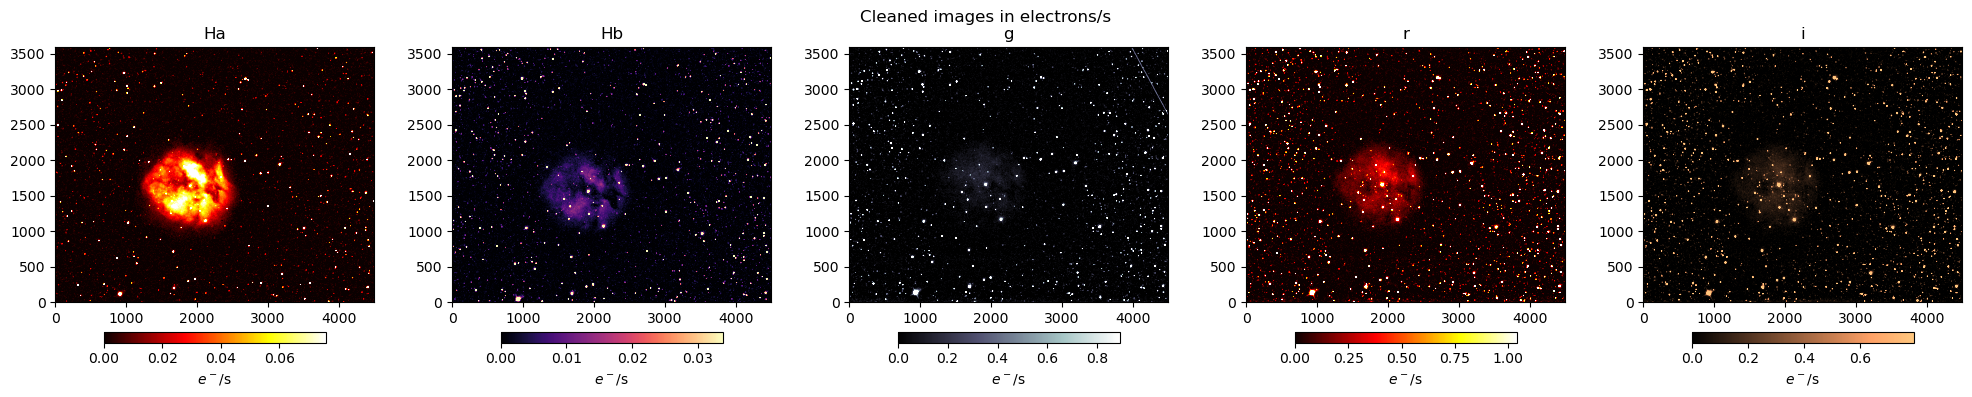

In [3]:
import numpy as np
from matplotlib import pyplot as plt

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle("Cleaned images in electrons/s")

for i, f in enumerate(filter):
    im = axes[i].imshow(image[f], clim=[0, np.quantile(image[f], 0.99)], cmap=filter_cmap[f], origin='lower')
    plt.colorbar(im, ax=axes[i], location='bottom', fraction=0.0375, pad=0.1, label="$e^-$/s")
    axes[i].set_title(f)

plt.tight_layout()
plt.show()



## Dithering

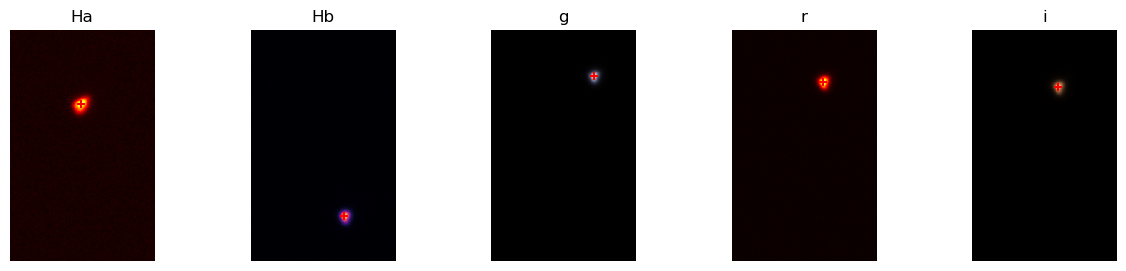

In [4]:
from photutils.centroids import centroid_quadratic

star_centroid = []

x_sx = 2850
x_dx = 2950
y_sx = 1700
y_dx = 1860

fig, ax = plt.subplots(1, 5, figsize=(15, 3))  # Create 1x5 grid

for i, f in enumerate(filter):
    rectangle = image[f][y_sx:y_dx, x_sx:x_dx]
    
    # Calculate centroid
    centroid = centroid_quadratic(rectangle)
    star_centroid.append(centroid)
    
    im = ax[i].imshow(rectangle, cmap=filter_cmap[f], origin='lower', aspect='equal')
    ax[i].scatter(centroid[0], centroid[1], marker='+', color='red')  # Mark centroid
    ax[i].set_title(f)
    ax[i].axis("off")


In [5]:
offsets = np.round(star_centroid[0] - star_centroid).astype(int) # refered to first exposure 

# align the image

for i, f in enumerate(filter):

    image[f] = np.roll(image[f], (offsets[i, 0], offsets[i, 1]), axis=(1, 0))

# save one fit file for Astrometry.net
hdu = fits.PrimaryHDU(image['r'])
hdu.writeto('data/r_aligned.fit', overwrite=True)


# Use Astrometry.net to build a map (x,y) -> (ra,dec)

In [6]:
# Stars recognized by ASTROMETRY.NET  https://nova.astrometry.net/upload
# x,y coordinates on detector and ra dec coordinates 

stars_astrometry = []

with fits.open("data/astrometry.fit") as hdul:
    if len(hdul) > 1:
        table_hdu = hdul[1]  

        if table_hdu.data.ndim == 1:
            table = np.stack(table_hdu.data)

        for row in table:
            stars_astrometry.append({'ra': row[0], 'dec': row[1], 'x': row[2], 'y': row[3]})



In [37]:
import pandas as pd

df = pd.DataFrame(stars_astrometry)
print(df.head(5))

           ra        dec            x            y
0  328.653284  47.155646   917.849304   113.173172
1  328.524359  47.122717  1677.976318   197.887039
2  328.161412  47.111895  3513.032471  1038.789429
3  328.142092  47.228769  3170.979980  1936.058228
4  328.264156  47.059291  3201.657471   395.491486


In [7]:
# TRANSFORM x,y in ra,dec

# Extract coordinates
x = np.array([star['x'] for star in stars_astrometry])
y = np.array([star['y'] for star in stars_astrometry])
ra = np.array([star['ra'] for star in stars_astrometry])
dec = np.array([star['dec'] for star in stars_astrometry])

# Define linear transformation model
def ra_model(coords, a0, a1, a2):
    x, y = coords
    return a0 + a1 * x + a2 * y

def dec_model(coords, b0, b1, b2):
    x, y = coords
    return b0 + b1 * x + b2 * y

from scipy.optimize import curve_fit
# Fit RA model
params_ra, _ = curve_fit(ra_model, (x, y), ra)
# Fit Dec model
params_dec, _ = curve_fit(dec_model, (x, y), dec)

# Transformation function
def xy_to_radec(x, y):
    """
    Transform grid of (x, y) to (RA, Dec) coordinates.
    """
    ra = params_ra[0] + params_ra[1] * x + params_ra[2] * y
    dec = params_dec[0] + params_dec[1] * x + params_dec[2] * y
    return ra, dec

def radec_to_xy(ra, dec):
    A = np.array([[params_ra[1], params_ra[2]],
                  [params_dec[1], params_dec[2]]])
    b = np.array([ra - params_ra[0], dec - params_dec[0]])
    # Solve the linear system A * [x, y] = b
    x, y = np.linalg.solve(A, b)
    return x, y
    

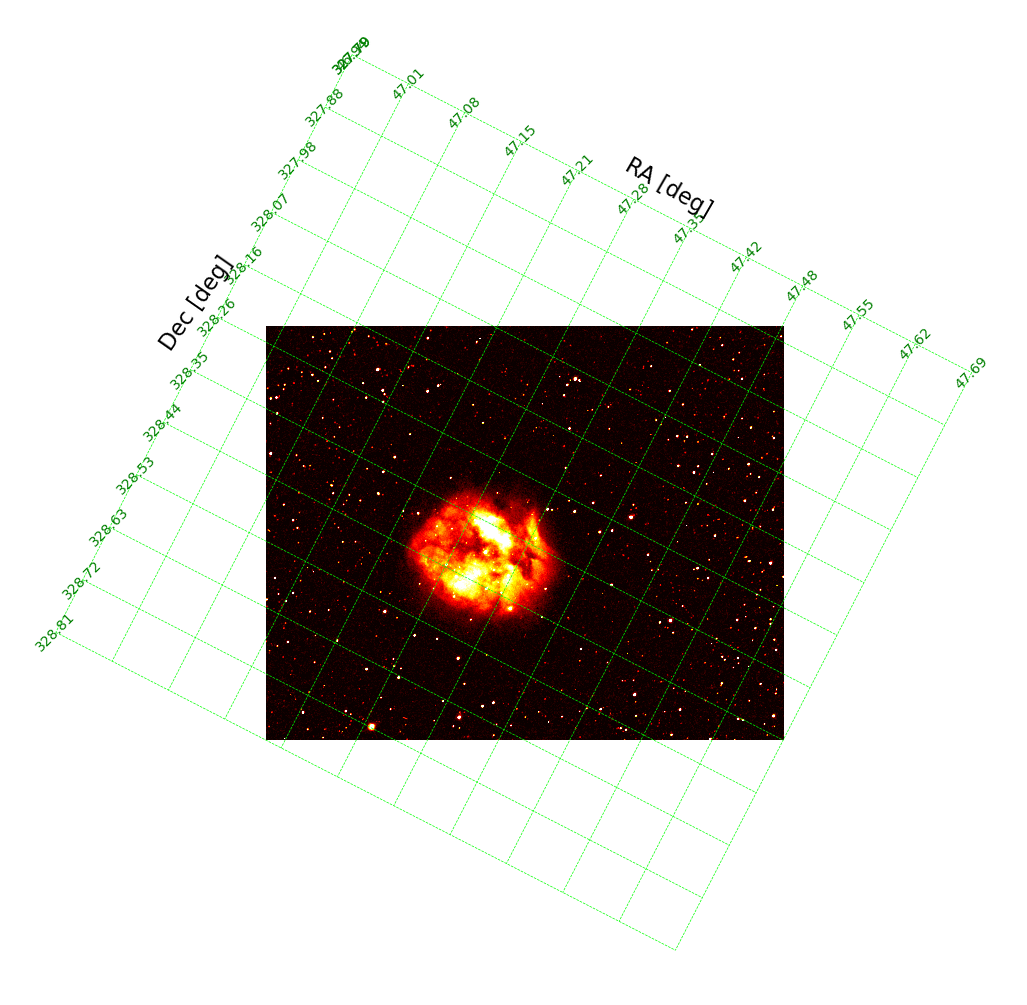

In [14]:
### === PLOT IMAGE WITH RA,DEC GRID === ###

ny, nx = image[filter[0]].shape

RA_min = xy_to_radec(nx, ny)[0]
RA_max = xy_to_radec(0, 0)[0]
Dec_min = xy_to_radec(nx, 0)[1]
Dec_max = xy_to_radec(0, nx)[1]

ra_range = np.linspace(RA_min, RA_max, 12)  # Example RA range
dec_range = np.linspace(Dec_min, Dec_max, 12)     # Example Dec range

# Grid of RA and Dec for plotting
ra_grid = []
dec_grid = []

# Collect RA constant grid lines
for ra in ra_range:
    decs = np.linspace(dec_range[0], dec_range[-1], 100)
    ras = np.full_like(decs, ra)
    ra_grid.append((ras, decs))

# Collect Dec constant grid lines
for dec in dec_range:
    ras = np.linspace(ra_range[0], ra_range[-1], 100)
    decs = np.full_like(ras, dec)
    dec_grid.append((ras, decs))

# Transform grid lines to pixel coordinates (x, y)
grid_lines_x = []
grid_lines_y = []

for ras, decs in ra_grid + dec_grid:
    x, y = radec_to_xy(ras, decs)
    grid_lines_x.append(x)
    grid_lines_y.append(y)



fig, axes = plt.subplots(figsize=(13,13))
plt.imshow(image['Ha'], clim=[0,np.quantile(image['Ha'], 0.99)], cmap=filter_cmap['Ha'], origin='lower')

for x, y in zip(grid_lines_x, grid_lines_y):
    plt.plot(y, x, color='lime', linestyle='--', linewidth=0.5)

last_ra = None  
for i in range(len(grid_lines_x)):
    ra_start, dec_start = xy_to_radec(grid_lines_x[i][0], grid_lines_y[i][0]) 

    if last_ra is None or ra_start != last_ra:
        last_ra = ra_start  
        if i != len(grid_lines_x):
            plt.text(grid_lines_y[i][0], grid_lines_x[i][0], f'{ra_start:.2f}', color='green', 
                     fontsize=10, rotation=45, ha='center', va='center') 

last_dec = None 
for i in range(len(grid_lines_y)):
    ra_start, dec_start = xy_to_radec(grid_lines_x[i][0], grid_lines_y[i][0]) 

    if last_dec is None or dec_start != last_dec:
        if i != len(grid_lines_y):
            plt.text(grid_lines_y[i][0], grid_lines_x[i][0], f'{dec_start:.2f}', color='green', 
                     fontsize=10, rotation=45, ha='center', va='center')
        last_dec = dec_start
        
plt.text(-600,3800, "Dec [deg]", color='black', fontsize=16, rotation=55,
         ha='center', va='center')

plt.text(3500,4800, "RA [deg]", color='black', fontsize=16, rotation=-30,
         ha='center', va='center')

plt.axis('off')
plt.show()

## CALIBRATION

**VEGA MAGNITUDES**

Uses Vega as reference. UBVRI filters system. Tied to the specific spectral energy distribution (SED) of Vega, making it less uniform across different passbands

$f_\nu$ is specific spectral flux density 

% V band magnitude:
$$m_{\text{V}} = -2.5 \log_{10} \left( \frac{f_{\text{,V}}}{f_{0\text{,V}}} \right)$$

% R band magnitude:
$$m_{\text{R}} = -2.5 \log_{10} \left( \frac{f_{\text{,R}}}{f_{0\text{,R}}} \right)$$




**AB MAGNITUDES**

Based on flux measurements that are calibrated in absolute units. "Flat" system in terms of the logarithmic scale for energy.
Magnitudes are still related to one spectral filter!

$f_\nu$ is specific spectral flux density 

% Monochromatic AB magnitude:
$$m_{\text{AB}} \approx -2.5 \log_{10} \left( \frac{f_{\nu}}{3631 \, \text{Jy}} \right)$$

% Simplified expression (with f_nu in Jansky):
$$m_{\text{AB}} = -2.5 \log_{10} f_{\nu} + 8.90$$

% Exact definition in cgs units:
$$m_{\text{AB}} = -2.5 \log_{10} f_{\nu} - 48.60$$

% Zero-point flux density:
$$f_{\nu,0} = 10^{\frac{48.60}{-2.5}} \approx 3.631 \times 10^{-20} \, \text{erg} \, \text{s}^{-1} \, \text{cm}^{-2} \, \text{Hz}^{-1}$$

% Bandpass AB magnitude:
$$m_{\text{AB}} \approx -2.5 \log_{10} \left( \frac{\int f_{\nu} (h \nu)^{-1} e(\nu)\, d\nu}{\int 3631 \, \text{Jy} \, (h\nu)^{-1} e(\nu) \, d\nu} \right)
$$

**FILTER TRANSMISSION**

Although SDSS (or other surveys) dispaly ugriz filter data, filters on TOBI are most probably different, because of different trasmission of the filter and also different response of the detector to different wavelength (different quantum efficiency). At first order the rapresentative wavelength of a filter is:

$$\lambda_\text{filter} = \frac{\lambda_{max}-\lambda_{min}}{2}$$

This works fine only when the filter is flat. A better definition is the effective wavelength, which is like a "mean" wavelength describing the filter's shape

$$\lambda_{eff} = \frac{\int T(\lambda) \lambda \, d\lambda}{\int T(\lambda) d\lambda}$$

Even better is the pivotal wavelength, which minimizes the difference between flux density in $f_\lambda$ and $f_\nu$ within the filter. It is defined as:

$$\lambda_{pivot} = \sqrt{\frac{\int T(\lambda) \lambda\, d\lambda}{\int \frac{T(\lambda)}{\lambda} \, d\lambda}}$$

and combines both the linear and inverse dependence on wavelength.

The convolution of the spectra with the filter's transmission + Q.E. gives the specific flux (which doesn't depend directly on the width or on the height of the filter curve, beeing normalized): 

$$f_{\lambda,V}\approx \frac{\int d\lambda T(\lambda)f(\lambda)}{\int d\lambda T(\lambda)}$$

it's a covolution, weighting. Important: two filters with the same centroid but different bandwidth or different heights will give the same specific flux $f_\lambda$. Of course the broader filter, or the higher, will give higher electron count rate ans so higher SNR.


Specific fluxes conversion: $f_\lambda d\lambda = f_\nu d\nu$ and $\nu\lambda = c$ gives $f_\lambda = f_\nu c/\lambda^2$ 

**INSTRUMENTAL RESPONSE**

C depends on the instrument and on the FILTER. It changes with time, mainly because of dust. Converts a flux in erg/cm^2s^1A^2 in electron per second rate. Analogic digital converter then gives DU. C is called ZERO POINT. 

$$f_\lambda = 10^{-C} N_e$$   integrated over the band

taking the log and multiplying left and right by -2.5:

$$-2.5\log(f_\lambda) = 2.5C - 2.5\log(N_e)$$

the term on left is the apparent magnitude of the source (real flux), while the first term on right is referred to as "zero point" and the second term as instrument magnitude:

$$m_{true} = Z.P. + m_i$$


**Filters on TOBI telescope**

Atik 16200 mono
7 positions 2” Filter wheel
- H-α (656nm, 3.5nm wide)
- H-β (486nm, 5.5nm wide)
- OIII (500nm, 4nm wide)
- SII (672nm, 4nm wide)
- g’ (477nm, ~150nm wide)
- r’ (658nm, ~140nm wide)
- i’ (806nm, ~150nm wide)

### Filter color transformations

TOBI_ha = SDSS_r -0.2568 * (SDSS_g-SDSS_r) + 0.1470

TOBI_hb =  SDSS_g -0.2322 * (SDSS_g-SDSS_r) + -0.0024

TOBI_g   = SDSS_g -0.1205 * (SDSS_g-SDSS_r) + 0.0012

TOBI_r    = SDSS_r -0.0061 * (SDSS_g-SDSS_r) + 0.0001

TOBI_i    = SDSS_i -0.0609 * (SDSS_r-SDSS_i) + 0.0049

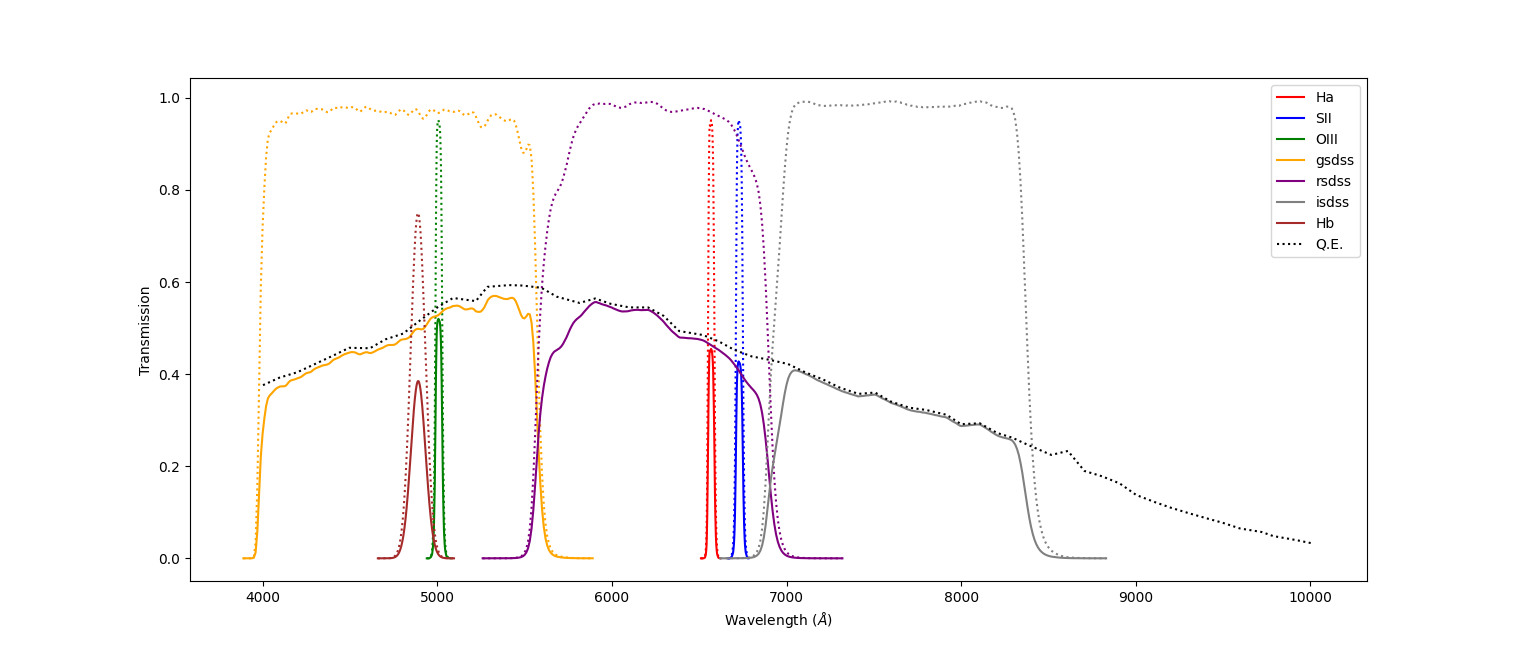

In [36]:
base_path = 'data/filters_transmission_curves/'
filter_names = [
    'tobi_ha.dat', 'tobi_hb.dat', 'tobi_gsdss.dat',
    'tobi_rsdss.dat', 'tobi_isdss.dat'
]

filter_paths = [base_path + name for name in filter_names]

filter_transmission = {}
for f, file_path in zip(filter, filter_paths ):
    data = np.loadtxt(file_path)
    
    x = data[:, 0]  
    y = data[:, 1]  
 
    filter_transmission[f] = {'wavelength': x, 'transmission': y}

filter_colors = {'Ha' : 'red', 'Hb': 'navy', 'r': 'pink', 'g': 'blue', 'i': 'orange'}

# SDSS

In [6]:
def TOBI_Ha(sdss_r,sdss_g):
    return sdss_r - 0.2568 * (sdss_g - sdss_r) + 0.1470

def TOBI_Hb(sdss_r,sdss_g):
    return sdss_g - 0.2322 * (sdss_g - sdss_r) - 0.0024

def TOBI_g(sdss_r,sdss_g):
    return sdss_g - 0.1205 * (sdss_g - sdss_r) + 0.0012

def TOBI_r(sdss_r,sdss_g):
    return sdss_r - 0.0061 * (sdss_g - sdss_r) + 0.0001

def TOBI_i(sdss_r,sdss_i):
    return sdss_i - 0.0609 * (sdss_r - sdss_i) + 0.0049


In [7]:
# SDSS

# Sloan Digital Sky Survey 
# Dataset contains only magnitudes in three filters
# Magnitudes values are not reliable, probably due to the fact that the stars lie in the galactic plane, a region highly affected by
# dust extinction, not the focus of SDSS extragalactic survey

file_path = "/home/robertoinfurna/Downloads/asu(5).fit"

stars_sdss = []

with fits.open(file_path) as hdul:
    if len(hdul) > 1:
        table_hdu = hdul[1]  

        for ra, dec, rmag, gmag, imag in zip(table_hdu.data['RA_ICRS'] , table_hdu.data['DE_ICRS'], 
                                             table_hdu.data['rmag'], table_hdu.data['gmag'], table_hdu.data['imag']):
            stars_sdss.append({
                'ra': ra,     # Right Ascension
                'dec': dec,   # Declination
                'r': rmag,    # r-band magnitude
                'g': gmag,    # g-band magnitude
                'i': imag     # i-band magnitude
            })


In [8]:
import pandas as pd

df = pd.DataFrame(stars_sdss)
print(df.head(5))

           ra        dec       r       g       i
0  328.483348  46.948540  14.761  14.924  14.688
1  328.635523  46.980694  14.173  14.356  14.105
2  328.621296  46.954329  14.149  14.138  16.213
3  328.612178  46.949804  14.393  14.744  14.745
4  328.644412  46.979664  14.131  14.371  14.416


In [21]:
# gives flux in filter, given the transmission and the spectra

from scipy.integrate import quad
from scipy.interpolate import interp1d

def specific_flux_lambda(spectrum_wavelength,flux,transmission_wavelength,transmission):
    """
    Convolution of spectra by filter transmission and Q.E.
    Works with specific flux per unit of wavelength and transmission curve defined in wavelength domain (armstrong)
    """
    spectrum = interp1d(spectrum_wavelength, flux, kind='linear', fill_value="extrapolate")
    transmission = interp1d(transmission_wavelength, transmission, kind='linear', fill_value="extrapolate")

    w_inf = transmission_wavelength[0]
    w_sup = transmission_wavelength[-1]
    
    flux_per_transmission, error = quad(lambda w: spectrum(w)*transmission(w), w_inf, w_sup)
    norm, error = quad(lambda w: transmission(w), w_inf, w_sup)

    return flux_per_transmission/norm 

def lambda_pivot(transmission_wavelength,transmission):
    """
    wavelengths expressed in armstrong
    """
    transmission = interp1d(transmission_wavelength, transmission, kind='linear', fill_value="extrapolate")

    w_inf = transmission_wavelength[0]
    w_sup = transmission_wavelength[-1]
    
    numerator,error = quad(lambda w: w*transmission(w), w_inf, w_sup)
    denominator,error = quad(lambda w: transmission(w)/w, w_inf, w_sup)

    return np.sqrt(numerator/denominator)

# AM I SURE ?!
def magnitude(spectrum_wavelength,flux,transmission_wavelength,transmission):
    """
    Specific flux per unit of wavelength must be transformed in specific flux per unit frequency  
    """
    f_lambda = specific_flux_lambda(spectrum_wavelength,flux,transmission_wavelength,transmission)
    lambda_p = lambda_pivot(transmission_wavelength,transmission)
    f_nu = f_lambda * lambda_p**2 / 2.99792458e18
    
    return -2.5 * np.log10(f_nu) - 48.60



# GAIA DR3 dataset

Gaia DR3 (Data Release 3) is the third public release of data from the Gaia mission, which is conducted by the European Space Agency (ESA). Gaia is a space telescope launched in 2013 to measure the positions, distances, and motions of stars across the Milky Way galaxy with high precision.

Gaia DR3, released in June 2022, provides an extensive catalog of astronomical data. Some of the key features include:

- Astrometry: Precise measurements of positions, distances, and motions of over 1.8 billion stars, enabling detailed mapping of the Milky Way.
- Photometry: Light measurements in different wavelengths (broadband optical) for millions of stars, helping to classify their types and physical characteristics.
- Spectroscopy: Data from the spectra of stars and other celestial objects, allowing scientists to study their composition, temperature, and radial velocities.
- Variability: Information on the brightness variations of stars, including pulsating stars, eclipsing binaries, and others.

- pmra (D), pmdec (D):

    Meaning: Proper motion in the right ascension (pmra) and declination (pmdec) directions. These describe how the star is moving across the sky.
    Unit: Milliarcseconds per year (mas/yr).
    How it’s computed: These values are derived from the star's position at different times, tracking its motion relative to more distant background stars.

- ruwe (E):

    Meaning: The Renormalized Unit Weight Error (RUWE) quantifies the quality of the astrometric solution (parallax and proper motion).
    How it’s computed: RUWE is derived from the variance of the fit to the star's position and motion over time. A value close to 1 indicates a good fit.

- phot_g_mean_mag (E):

    Meaning: The mean magnitude in the GAIA G-band.
    Unit: Magnitude (mag).
    How it’s computed: This is the observed brightness of the star in the G-band, which GAIA measures through its photometric observations.

- bp_rp (E):

    Meaning: The difference between the magnitudes in the blue photometric band (BP) and the red photometric band (RP). This is also known as the color index.
    Unit: Magnitude (mag).
    How it’s computed: GAIA measures the star’s brightness in both the blue (BP) and red (RP) bands, and the difference between these values gives the color index, which is related to the star's temperature.

- radial_velocity (E):

    Meaning: The radial velocity of the star, or how fast it is moving towards or away from us along the line of sight.
    Unit: km/s.
    How it’s computed: This is derived from the Doppler shift of the star's spectral lines, which GAIA measures. The shift indicates whether the star is moving toward or away from Earth.

1- phot_variable_flag (13A):

    Meaning: A flag indicating whether the star is variable in brightness.
    How it’s computed: This flag is set based on whether the star shows significant variability in its brightness over time.

- non_single_star (I):

    Meaning: A flag indicating whether the star is part of a binary or multiple star system.
    How it’s computed: This is determined through astrometric measurements, such as the star's motion or other evidence of companions.

12. has_xp_continuous, has_xp_sampled, has_rvs, has_epoch_photometry, has_epoch_rv, has_mcmc_gspphot, has_mcmc_msc (L):

    Meaning: These are flags indicating whether certain types of data or analyses are available for the star.
    How it’s computed: These are binary flags indicating the presence of continuous photometry, radial velocity data, and other measurements.

- teff_gspphot (E):

    Meaning: The effective temperature of the star.
    Unit: Kelvin (K).
    How it’s computed: The effective temperature is derived from the star's color and luminosity using models of stellar atmospheres, typically from the GAIA photometric data and spectroscopic observations.

- logg_gspphot (E):

    Meaning: The surface gravity of the star, measured in log units (logarithmic scale).
    Unit: log(cm/s²).
    How it’s computed: This is derived from the star’s luminosity, radius, and mass. It’s related to the star's stage in its lifecycle.

- mh_gspphot (E):

    Meaning: The metallicity of the star, given in logarithmic units (dex).
    Unit: dex.
    How it’s computed: Metallicity is derived from the star’s spectrum and photometric measurements. It indicates the abundance of elements heavier than hydrogen and helium in the star.

- distance_gspphot (E):

    Meaning: The distance to the star.
    Unit: Parsecs (pc).
    How it’s computed: The distance is derived from the parallax measurements using the formula d=1/parallaxd=1/parallax (in arcseconds).

- azero_gspphot, ag_gspphot, ebpminrp_gspphot (E):

    Meaning: These are extinction and reddening parameters that describe how the star’s light is affected by interstellar dust.
    Unit: Magnitude (mag).
    How it’s computed: These are computed through photometric observations of the star and its surroundings, using models for interstellar dust.

**GAIA Sampled XP Spectra** refer to the low-resolution prism-dispersed spectra obtained by the BP/RP (Blue Photometer / Red Photometer) spectrometers on board the GAIA space telescope. These spectra are part of the XP (Xp = eXtra Photometric) data, and they provide crucial spectral information across a broad wavelength range. BP/RP Spectroscopy: BP (Blue Photometer): Covers the 330–680 nm range. RP (Red Photometer): Covers the 640–1050 nm range. These instruments disperse light at low resolution (~20–100), meaning they provide broad spectral energy distribution (SED) information rather than high-resolution spectral lines.



In [145]:
### === Open data catalogue === ###

with fits.open('data/GAIA_field_m>13.fits') as hdul:
    #print(hdul[1].header)
    columns = hdul[1].columns.names  
    GAIA_table = hdul[1].data

import pandas as pd
df = pd.DataFrame(GAIA_table)

from IPython.display import display, HTML
display(HTML("""
<style>
    .scrollable-table-container {
        overflow: auto; /* Enables scrolling */
        max-height: 500px; /* Set maximum height for vertical scrolling */
        border: 1px solid #ccc; /* Optional: Add border for clarity */
        padding: 5px;
    }
    .scrollable-table-container table {
        display: block; /* Ensures proper rendering for wide tables */
        white-space: nowrap; /* Prevent text wrapping in cells */
    }
</style>
<div class="scrollable-table-container">
""" + df.to_html(index=False) + "</div>"))


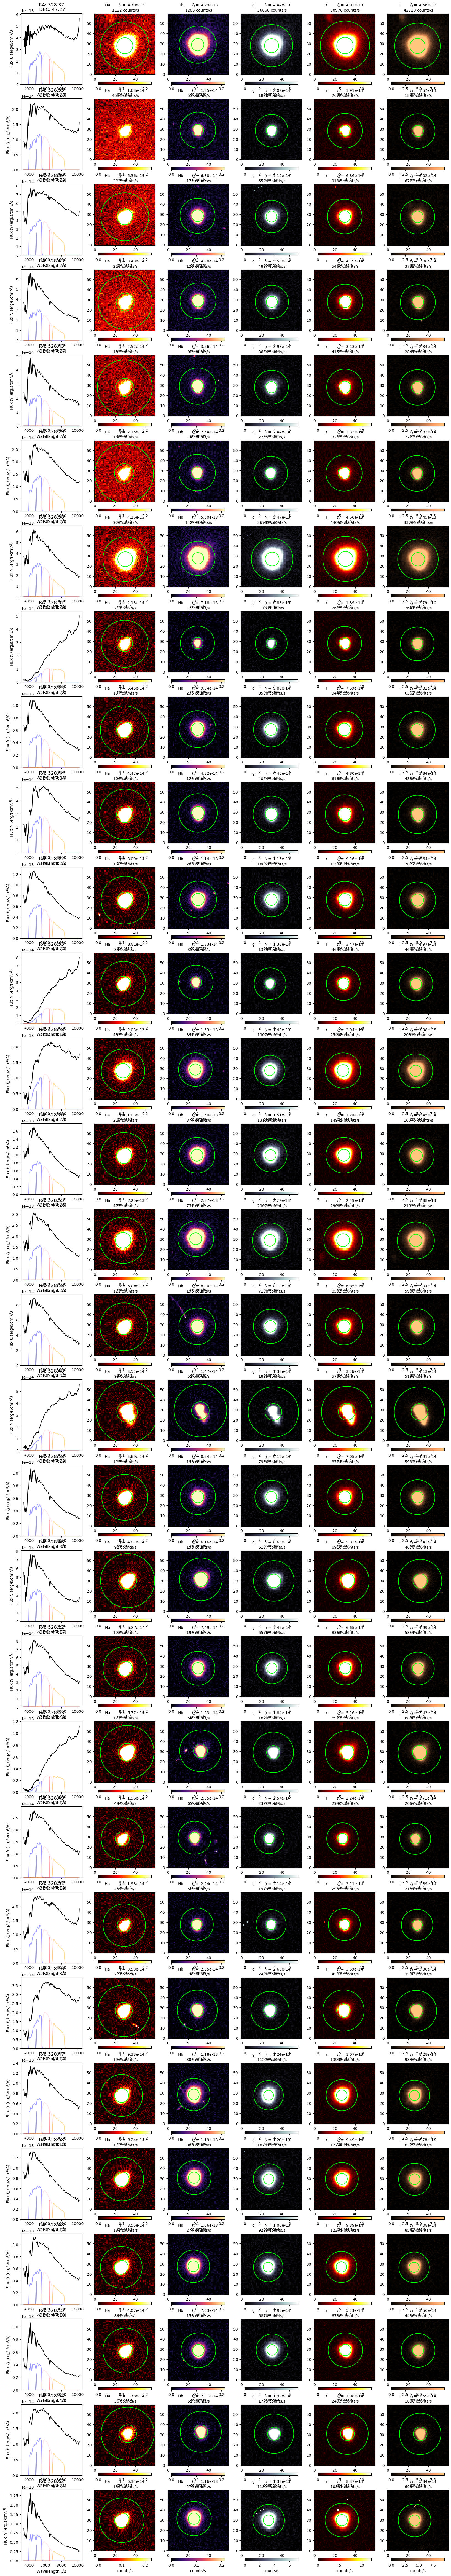

In [146]:
### === Make a list of stars for the calibration === ###

from photutils.aperture import CircularAperture, aperture_photometry
from photutils.centroids import centroid_com
from astropy.modeling import models, fitting
from matplotlib.patches import Circle

# download xp spectra
from astroquery.gaia import Gaia
retrieval_type = 'XP_SAMPLED'     # Options are: 'EPOCH_PHOTOMETRY', 'MCMC_GSPPHOT', 'MCMC_MSC', 'XP_SAMPLED', 'XP_CONTINUOUS', 'RVS', 'ALL'
data_structure = 'INDIVIDUAL'     # Options are: 'INDIVIDUAL' or 'RAW'
data_release   = 'Gaia DR3'       # Options are: 'Gaia DR3' (default), 'Gaia DR2'
datalink = Gaia.load_data(ids=GAIA_table['source_id'],data_release=data_release, retrieval_type=retrieval_type, data_structure=data_structure);
#dl_keys  = [inp for inp in datalink.keys()]


fig, ax = plt.subplots(30, 6, figsize=(20, 120))

stars_gaia = []

for i in range(30): # range(len(GAIA_table)):

    source_id = GAIA_table[i]['source_id']  
    
    ra = GAIA_table[i]['ra']
    dec = GAIA_table[i]['dec']

    x,y = radec_to_xy(ra,dec)
    
        
    wavelengths = np.array(datalink[f"XP_SAMPLED-Gaia DR3 {GAIA_table['source_id'][i]}.xml"][0].to_table().as_array()['wavelength'])
    flux = np.array(datalink[f"XP_SAMPLED-Gaia DR3 {GAIA_table['source_id'][i]}.xml"][0].to_table().as_array()['flux'])
    flux_err = np.array(datalink[f"XP_SAMPLED-Gaia DR3 {GAIA_table['source_id'][i]}.xml"][0].to_table().as_array()['flux_error'])
    
    w = 10 * wavelengths  # wavelength in armstrong (GAIA original data gives wavelength in nm)
    flux = 1.e2 * flux  # specific flux in erg/s/cm2/armstrong (GAIA original data gives fluxes in W/m^2/nm)
    flux_err = 1.e2 * flux_err

    ###
    
    ax[i][0].plot(w, flux,c='black')
    ax[i][0].set(xlabel = 'Wavelength (Å)', ylabel = 'Flux $f_\lambda$ (erg/s/cm²/Å)')

    

    ax[i][0].set_title(f"RA: {ra:.2f}\n DEC: {dec:.2f}")

    ###
    
    f_lambda = {}
    mag = {}
    
    for f in filter:
        w_f = filter_transmission[f]['wavelength'] 
        T_f = filter_transmission[f]['transmission']
        transmission_fun = interp1d(w_f, T_f, kind='linear', fill_value="extrapolate")

        ax[i][0].plot(w,flux*transmission_fun(w),c=filter_colors[f],alpha=0.4)
        ax[i][0].set_ylim(bottom=0) 
        
        
        f_lambda[f] = specific_flux_lambda(w,flux,w_f,T_f)
        mag[f] = magnitude(w,flux,w_f,T_f)


    ### 

    
    photometry = {}

    for j,f in enumerate(filter):
    
        x,y = radec_to_xy(ra,dec)
            
        l = 30
        rectangle = image[f][int(y-l):int(y+l), int(x-l):int(x+l)]
        y_grid, x_grid = np.mgrid[:rectangle.shape[0], :rectangle.shape[1]]
        g_init = models.Gaussian2D(amplitude=rectangle.max(), x_mean=l, y_mean=l, x_stddev=5, y_stddev=5)
        fit = fitting.LevMarLSQFitter()
        g_fit = fit(g_init, x_grid, y_grid, rectangle)
                
        refined_x = x - l + g_fit.x_mean.value
        refined_y = y - l + g_fit.y_mean.value
    
        sigma_x, sigma_y = g_fit.x_stddev.value, g_fit.y_stddev.value
        fwhm = (2.355 * sigma_x + 2.355 * sigma_y)/2

        # Create a CircularAperture object with a radius of 3 times the FWHM
        # Why 3 times the FWHM? This is a common choice to include most of the star's light.
        aperture = CircularAperture((refined_x, refined_y), r = 3 * fwhm)
        phot_table = aperture_photometry(image[f], aperture)  
        counts_s = phot_table['aperture_sum'][0]
        
        photometry[f] = {
                    'counts_s': counts_s,  # Flux
                    'centroid': (refined_x, refined_y),         # Centroid
                    'aperture': 3  * fwhm,                      # photomoetric aperture is 3 times the FWHM  (Why?)
                }

        im = ax[i,j+1].imshow(rectangle, clim=[0, np.quantile(image[f],0.999)], cmap=filter_cmap[f], origin='lower')
        plt.colorbar(im, ax=ax[i,j+1], location='bottom', fraction=0.0375, pad=0.1, label="counts/s")
        circle = Circle((g_fit.x_mean.value, g_fit.y_mean.value), fwhm, edgecolor='lime', facecolor='none', linewidth=1.5)
        ax[i,j+1].add_patch(circle)
        circle = Circle((g_fit.x_mean.value, g_fit.y_mean.value), 3*fwhm, edgecolor='lime', facecolor='none', linewidth=1.5)
        ax[i,j+1].add_patch(circle)
    
        ax[i,j+1].set_title(f"{f:s}\t $f_\lambda =$ {f_lambda[f]:.2e} \n {counts_s:.0f} counts/s", fontsize=10)

    ###
    
    stars_gaia.append({'ra': ra, 'dec': dec, 'x': x, 'y': y, 'centroid': (refined_x, refined_y),
                       'f_lambda': f_lambda,
                       'mag': mag, 
                       'photometry': photometry})


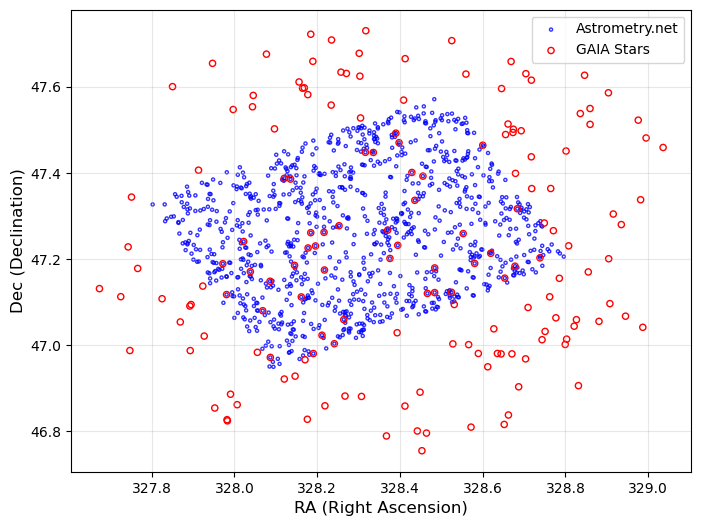

In [66]:
# Extract RA and Dec for GAIA stars from the dictionary

gaia_ra = [star['ra'] for star in stars_gaia]
gaia_dec = [star['dec'] for star in stars_gaia]
sdss_ra = [star['ra'] for star in stars_sdss]
sdss_dec = [star['dec'] for star in stars_sdss]
astrometry_ra = [star['ra'] for star in stars_astrometry]
astrometry_dec = [star['dec'] for star in stars_astrometry]

# Plot the scatter plots
plt.figure(figsize=(8, 6))  # Optional: Set figure size for better visualization
plt.scatter(astrometry_ra, astrometry_dec, edgecolors='blue', facecolors='none', s=5, alpha=0.8, label='Astrometry.net')
plt.scatter(gaia_ra, gaia_dec, edgecolors='red', facecolors='none', s=20, label='GAIA Stars')
#plt.scatter(sdss_ra, sdss_dec, edgecolors='green', facecolors='none', s=30, label='SDSS Stars')

# Add labels and legend
plt.xlabel('RA (Right Ascension)', fontsize=12)
plt.ylabel('Dec (Declination)', fontsize=12)
plt.legend(loc='best')  # Add a legend to differentiate datasets
plt.grid(alpha=0.3)  # Optional: Add a light grid for better readability

# Show the plot
plt.show()


**CONVOLUTION**

The convolution of the spectra with the filter's transmission + Q.E. gives the specific flux (which doesn't depend directly on the width or on the height of the filter curve, beeing normalized): 

$$f_{\lambda,V}\approx \frac{\int d\lambda T(\lambda)f(\lambda)}{\int d\lambda T(\lambda)}$$

it's a covolution, a sort of weighted mean. Important: two filters with the same centroid but different bandwidth or different heights will give the same specific flux $f_\lambda$. Of course the broader filter, or the higher, will give higher electron count rate ans so higher SNR.

**Apertures**

Recommended Aperture Sizes:

    Aperture Radius:
    A commonly used radius is r≈1.2×FWHMr≈1.2×FWHM. This captures around 90-95% of the total flux for a well-isolated point source.

    Variations for Specific Conditions:
        Crowded Fields: Use a smaller radius (e.g., r≈0.7×FWHM) to avoid flux contamination from nearby stars.
        High Background Noise: Increase the aperture radius only slightly (up to 2×FWHM) but apply more rigorous background subtraction techniques.
        Extended Sources or Nebulae: Consider fitting PSF models to integrate the flux instead of relying solely on a fixed aperture.

In [151]:
my_list = [10, 20, 30, 40]
del my_list[1]
print(my_list)

[10, 30, 40]


**INSTRUMENTAL RESPONSE**

C depends on the instrument and on the FILTER. It changes with time, mainly because of dust. Converts a flux in erg/cm^2s^1A^2 in electron per second rate. Analogic digital converter then gives DU. C is called ZERO POINT. 

$$f_\lambda = 10^{-C} N_e$$   integrated over the band

taking the log and multiplying left and right by -2.5:

$$-2.5\log(f_\lambda) = 2.5C - 2.5\log(N_e)$$

the term on left is the apparent magnitude of the source (real flux), while the first term on right is referred to as "zero point" and the second term as instrument magnitude:

$$m_{true} = Z.P. + m_i$$

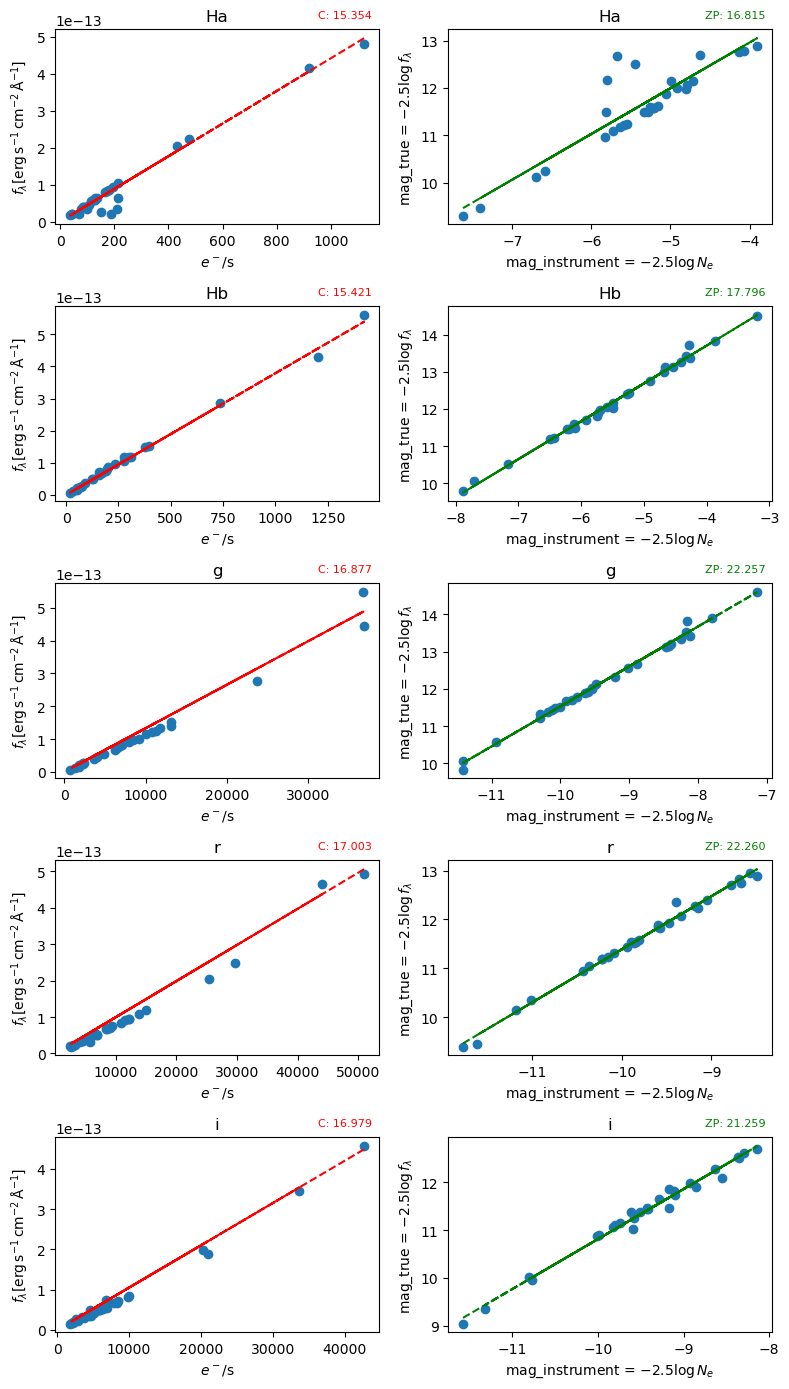

In [152]:
from scipy.stats import linregress

# Extract flux values from stars_calib

fig, ax = plt.subplots(5,2,figsize=(8, 14))

C = {}
ZP = {}

del stars_gaia[1]

for i, f in enumerate(filter):
    ax[i][0].set_title(f)
    ax[i][1].set_title(f)

    counts_s = [star['photometry'][f]['counts_s'] for star in stars_gaia]
    f_lambda = np.array([star['f_lambda'][f] for star in stars_gaia])
    
    # Plot the counts vs true specific flux
    ax[i][0].plot(counts_s, f_lambda, 'o')
    ax[i][0].set_xlabel('$e^-$/s')
    ax[i][0].set_ylabel('${f_\lambda} [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, \u00c5^{-1}}]$')

    # Compute linear fit using filtered data
    slope, intercept, _, _, _ = linregress(counts_s, f_lambda)
    #x_grid = np.linspace(0, max(counts_s), 100)
    fit_line = slope * np.array(counts_s) #x_grid + intercept
    
    # Store C value
    C[f] = -np.log10(slope)

    # Plot linear fit line
    ax[i][0].plot(counts_s, fit_line, '--', color='red')

    # Annotate the plot with the value of C
    text = f"C: {C[f]:.3f}"
    ax[i][0].text(0.98, 1.1, text, fontsize=8, color='red',
                  transform=ax[i][0].transAxes, ha='right', va='top')

    # Magnitudes
    mag_true = np.array([star['mag'][f] for star in stars_gaia])
    mag_instrument = -2.5 * np.log10(counts_s)
    
    # Plot mag_instrument vs mag_true
    ax[i][1].plot(mag_instrument, mag_true, 'o')
    ax[i][1].set_xlabel('mag_instrument = $-2.5\log{N_e}$')
    ax[i][1].set_ylabel('mag_true = $-2.5\log{f_\lambda}$')

    # Compute linear fit for magnitudes
    slope, intercept, _, _, _ = linregress(mag_instrument, mag_true)
    fit_line_mag = slope * np.array(mag_instrument) + intercept 

    # Store ZP (Zero-Point)
    ZP[f] = intercept

    # Plot linear fit line for magnitudes
    ax[i][1].plot(mag_instrument, fit_line_mag, '--', color='green')

    # Annotate the plot with the value of ZP
    text = f"ZP: {ZP[f]:.3f}"
    ax[i][1].text(0.98, 1.1, text, fontsize=8, color='green',
                  transform=ax[i][1].transAxes, ha='right', va='top')

plt.tight_layout()
plt.show()


## From specific flux to flux

To calculate the total flux over a filter, you often need to multiply the measured flux density by the effective width of the filter:
$F_\text{filter}\sim f_{\lambda,eff}\times\Delta\lambda_\text{filter}$

The effective width of the filter is often calculated as:

$$\Delta\lambda_\text{filter} = \frac{\int T(\lambda)d\lambda}{\text{max}(T(\lambda))}$$

This gives a total flux in units like $\mathrm{erg\, s^{-1}\, cm^{-2}}$ instead of flux per unit wavelength. The same holds for surface brightness. 


If you're converting between magnitudes and physical fluxes, the width of the filter is important for calculating integrated flux values over the entire filter band. The total flux may depend not just on the flux at a specific wavelength but over the whole bandpass.

For instruments integrating signal over a broad range of wavelengths, multiplying by the filter width helps compute the correct flux per unit time, as the detector effectively averages the flux across the bandpass.

In [5]:
def filter_width(transmission_wavelength,transmission):
    """
    Computes width of a filter in armstrongs
    """
    transmission_fun = interp1d(transmission_wavelength, transmission, kind='linear', fill_value="extrapolate")

    w_inf = transmission_wavelength[0]
    w_sup = transmission_wavelength[-1]
    
    transmission_integral, error = quad(lambda w: transmission_fun(w), w_inf, w_sup)

    return transmission_integral/max(transmission)

delta_filter = {}
for f in filter: 
    delta_filter[f] = filter_width(filter_transmission[f]['wavelength'],filter_transmission[f]['transmission'])

print(delta_filter)

{'Ha': 37.748305404111456, 'Hb': 104.84238111311946, 'g': 1329.7185282478872, 'r': 1147.9445160467624, 'i': 1181.1994305343355}


## Surface Brightness

If we express specific surface brightness in terms of angular units, we are essentially looking at the amount of flux emitted per unit area on the sky, normalized by the solid angle corresponding to the angular size of the source.

The typical unit for specific surface brightness in terms of arcseconds squared is:

Units of Specific Surface Brightness (per unit wavelength, in $\mathrm{arcsec^{-2}}$):

$$[I_\lambda] = \mathrm{erg\, s^{-1}\, cm^{-2}\, \mathring{A}^{-1}\, arcsec^{-2}}$$




***Flux and Intensity***
The relationship between flux and intensity depends on the geometry of the system, particularly the solid angle over which the radiation is spread. The specific flux $f_\nu$ observed at a given point is related to the specific intensity $I_\nu$ integrated over the solid angle subtended by the source.

If $\Omega$ is the solid angle (in steradians) subtended by the source at the observer, then:

$$f_\nu = I_\nu \cdot \Omega$$

***Surface Brightness and Intensity***
The specific surface brightness $I_\nu$ at a point on the sky is just the specific intensity measured in units of area per unit solid angle, normalized to the area of the sky:

- For a point source, the intensity $I_\nu$ is the same as the surface brightness.
- For an extended source (such as a galaxy), the surface brightness refers to the intensity per unit area on the sky (e.g., per arcsecond squared), while intensity refers to the intrinsic brightness of the source in terms of physical area and solid angle.


***Surface Brightness and Flux in Annuli or Apertures***
In the case of extended sources, you might calculate the total flux in an aperture (e.g., in circular annuli) by integrating the specific surface brightness $I_\nu$ over the area of the aperture (projected onto the sky).

For an annular region with angular dimensions $\theta_{\mathrm{in}}$ and $\theta_{\mathrm{out}}$, the flux can be calculated as:

$$\text{Total Flux} = \int_{\theta_{\mathrm{in}}}^{\theta_{\mathrm{out}}} I_\nu \, d\Omega$$


where $d\Omega = \sin(\theta) d\theta d\phi$ is the differential solid angle in spherical coordinates.



In [15]:
# surface brightness 
# Devide by the area of each pixel

# Multiply for each filter width to have the correct line brightness 

angular_size_pixel_TOBI = 0.44  # arcesc per pixel

image_cal = {}

for i, f in enumerate(filter):
    
    image_cal[f] = 10**-C[f] * delta_filter[f] * image[f] / angular_size_pixel_TOBI**2

import gc
del image
gc.collect();

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle("Cleaned images in electrons/s")

for i, f in enumerate(filter):
    im = axes[i].imshow(image[f], clim=[0, np.quantile(image[f], 0.99)], cmap=filter_cmap[f], origin='lower')
    plt.colorbar(im, ax=axes[i], location='bottom', fraction=0.0375, pad=0.1, label="$e^-$/s")
    axes[i].set_title(f)

plt.tight_layout()
plt.show()

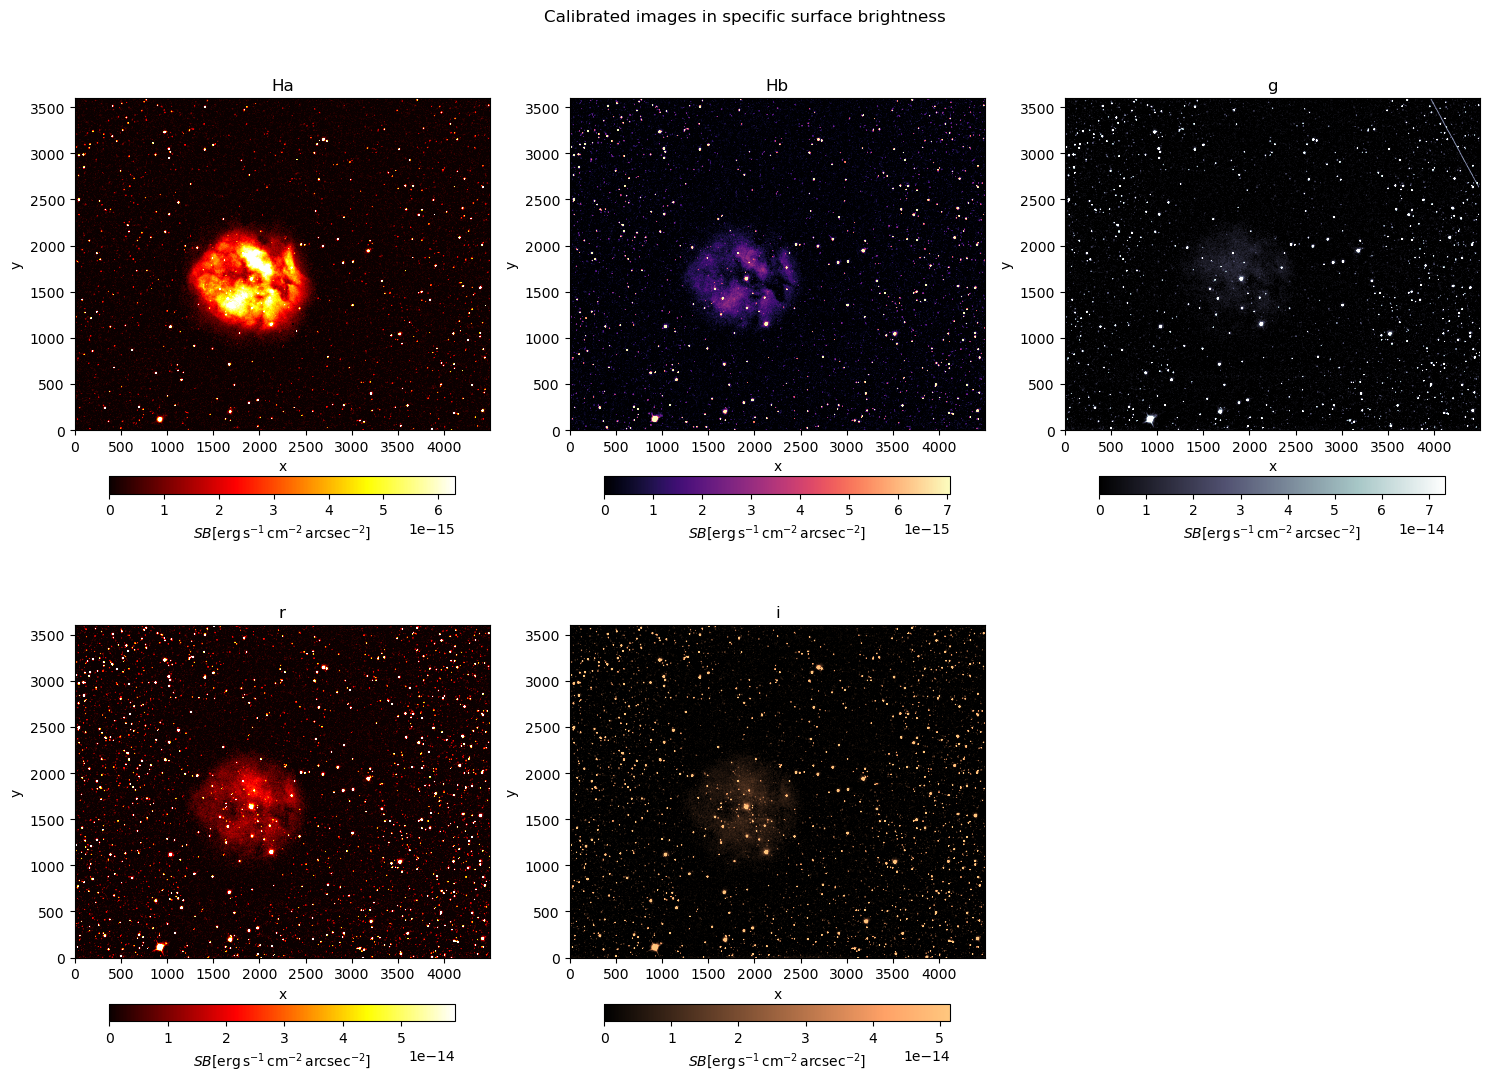

In [16]:
# Plotting CALIBRATED images with celestial coordinates

fig, axes = plt.subplots(2, 3, figsize=(15, 11))
fig.suptitle("Calibrated images in specific surface brightness")
axes = axes.flatten()

for i, f in enumerate(filter):
    im = axes[i].imshow(image_cal[f], clim=[0, np.quantile(image_cal[f], 0.99)], cmap=filter_cmap[f], origin='lower')
    plt.colorbar(im, ax=axes[i], location='bottom', fraction=0.0375, pad=0.1, label="$SB  [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, arcsec^{-2}}]$")
    axes[i].set_title(f)
    axes[i].set_xlabel("x")
    axes[i].set_ylabel("y")

axes[-1].axis('off')

plt.tight_layout()
plt.show()


# ERROR

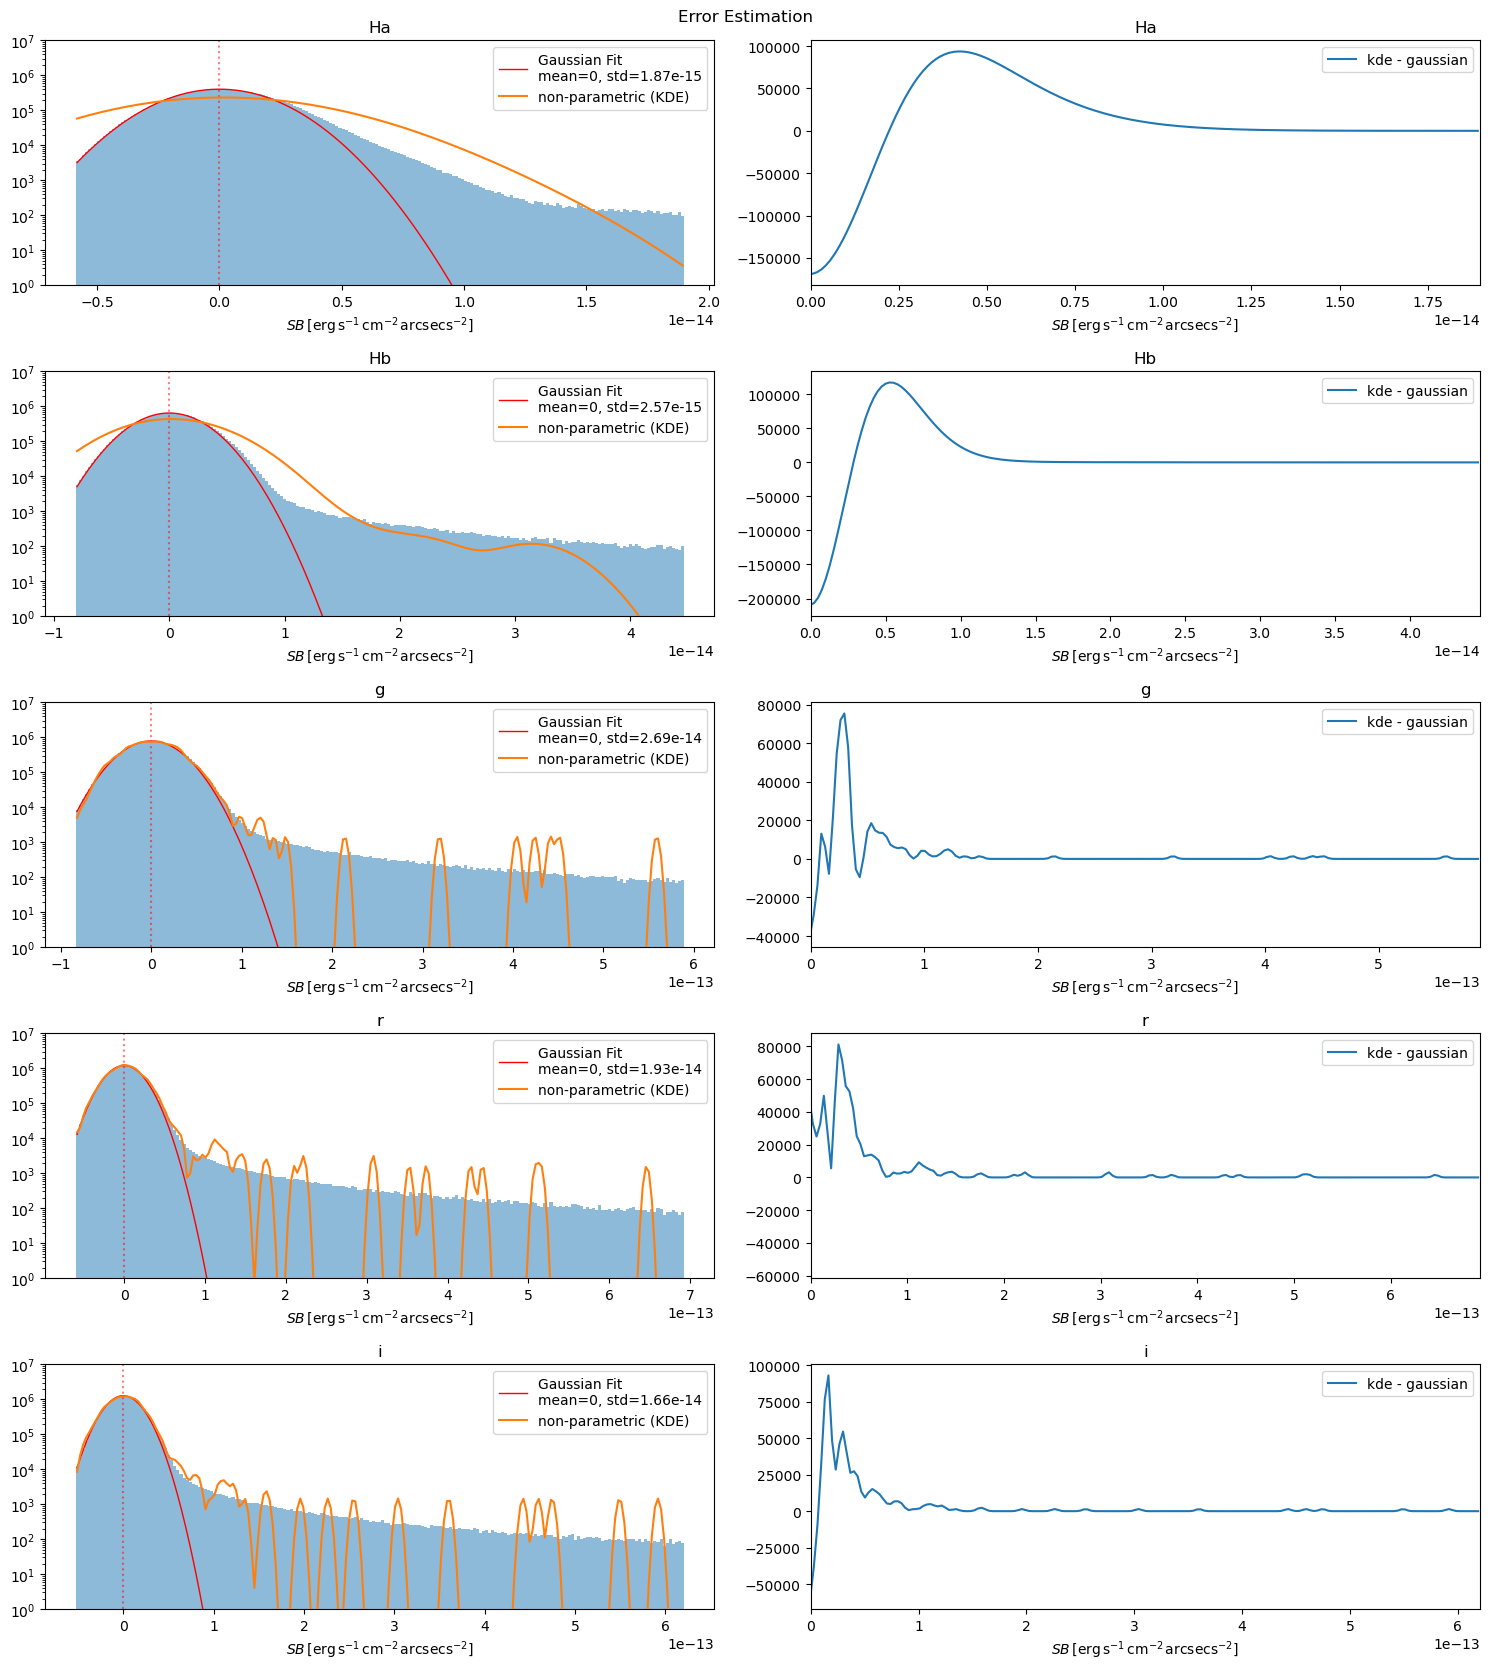

In [17]:
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

fig, ax = plt.subplots(5,2,figsize=(15, 17))
fig.suptitle("Error Estimation")

sigma = {}

for i, f in enumerate(filter):

    flattened_image = image_cal[f].flatten() 

    lower_threshold = np.quantile(flattened_image, 0.001)
    upper_threshold = np.quantile(flattened_image, 0.999)
    flattened_image = flattened_image[(flattened_image >= lower_threshold) & (flattened_image <= upper_threshold)]
    
    bin_edges = np.linspace(min(flattened_image),max(flattened_image), 200)

    hist, bins, _  = ax[i,0].hist(flattened_image, bins=bin_edges, alpha=0.5)  
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Fit a Gaussian to the NEGATIVE data only
    flattened_image_negative = flattened_image[flattened_image<0]
    mean, std = norm.fit(np.concatenate((flattened_image_negative,-flattened_image_negative)))
    sigma[f] = std

    normalization = max(hist) * (std*np.sqrt(2*np.pi))
    gaussian_curve = norm.pdf(bin_centers, mean, std) * normalization
    ax[i,0].plot(bin_centers, gaussian_curve, label=f"Gaussian Fit\nmean=0, std={std:.2e}", color='red', lw=1)
    ax[i,0].axvline(x=0,linestyle=':',c='r',alpha=0.5)
    
    # Kernel Density Estimation for the full distribution    
    kde = KernelDensity(bandwidth=3e-15, kernel='gaussian')
    flattened_image_small = np.random.choice(flattened_image, size=5000, replace=False)
    kde.fit(flattened_image_small[:, None])
    dens_kde = np.exp(kde.score_samples(bin_centers[:, None]))
    kde_normalized = dens_kde / dens_kde.sum() * hist.sum()
    ax[i,0].plot(bin_centers, kde_normalized, '-', color='C1', zorder=3,label="non-parametric (KDE)")

    ax[i,0].set_ylim(1,1e7)
    ax[i,0].set_yscale("log")
    
    ax[i,0].set_title(f)
    ax[i,0].set_xlabel("$SB \\, [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, arcsecs^{-2}}]$")
    ax[i,0].legend()
    
    # Distribution of photon from astrophysical sources only (stars and nebula)
    ax[i,1].plot(bin_centers,kde_normalized-gaussian_curve, label = "kde - gaussian")

    ax[i,1].set_title(f)
    ax[i,1].set_xlim(0,upper_threshold)
    ax[i,1].set_xlabel("$SB \\, [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, arcsecs^{-2}}]$")
    ax[i,1].legend()

plt.tight_layout()
plt.show()

In [19]:
output_folder = "data/cleaned_calibrated"

# Loop through each filter's image data
for f in filter:

    # Create the FITS file path
    fit_filename = os.path.join(output_folder, f"{f}_calibrated.fit")

    # Primary HDU: The science image
    primary_hdu = fits.PrimaryHDU(data=image_cal[f])

    header = primary_hdu.header
    header['sigma'] = sigma[f]
    
    # ra_dec conversion_functions
    # Store transformation parameters in the header
    header['RA_A0'] = params_ra[0]
    header['RA_A1'] = params_ra[1]
    header['RA_A2'] = params_ra[2]
    header['DEC_B0'] = params_dec[0]
    header['DEC_B1'] = params_dec[1]
    header['DEC_B2'] = params_dec[2]
    
    # Save the calibrated filter as a FITS file
    primary_hdu.writeto(fit_filename, overwrite=True)

    